# Trotter resource counts

## Setup

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

import openfermion as of
from openfermionpyscf import run_pyscf
from openfermion.chem import geometry_from_pubchem, MolecularData

import qiskit
import qiskit.qasm3
import qiskit_ibm_runtime
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter, SuzukiTrotter

import convert
import modified_hubbard
import openfermion_helper
import kcommute

In [16]:
# Parameters.
hamiltonian_name: str = "hubbard"
threshold: float = 0.01  # Remove terms in Hamiltonian whose coefficients are smaller than this value in magnitude.

ibm_computer: str = "ibm_fez"  # IBM computer to compile to.

cnots_crude = []
cnots_group = []
cnots_pauli = []

# For Hubbard model only.
nvals = [2, 3, 4, 5, 6, 7, 8]
for n in nvals:
    print("Status: n = ", n)
    xdim: int = n  # Only for Hubbard, the x-dimension of the Hubbard model.
    ydim: int = n  # Only for Hubbard, the y-dimension of the Hubbard model.
    
    hamiltonian = of.hamiltonians.fermi_hubbard(xdim, ydim, 1.0, 1.0, spinless=True)
    print(f"Fermionic Hamiltonian has {len(hamiltonian.terms)} term(s).")
    
    hamiltonian.compress(abs_tol=threshold)
    print(f"Compressed Fermionic Hamiltonian has {len(hamiltonian.terms)} term(s).")
    
    hamiltonian_openfermion = of.jordan_wigner(hamiltonian)
    
    nqubits = openfermion_helper.get_num_qubits(hamiltonian_openfermion)
    nterms = len(hamiltonian_openfermion.terms)
    
    print(f"Qubit Hamiltonian acts on {nqubits} qubit(s) and has {nterms} term(s).")
    
    hamiltonian = openfermion_helper.preprocess_hamiltonian(
        hamiltonian_openfermion,
        drop_term_if=[lambda term: term == ()],
        verbose=True,
    )  # Drop identity and convert to Cirq PauliSum.
    
    nterms = len(hamiltonian)
    nqubits = len(hamiltonian.qubits)
    
    print(f"\n\nPre-processed qubit Hamiltonian acts on {nqubits} qubit(s) and has {nterms} term(s).")
    
    # """Crude estimate."""
    num_cnots_crude: int = 0
    for term in hamiltonian:
        num_cnots_crude += 2 ** (len(term.qubits) - 1)
    
    print("Crude CNOTs:", num_cnots_crude)
    cnots_crude.append(num_cnots_crude)
    
    # """Estimate using grouping + diagonaliztion + exp(Z...Z) "ladder"."""
    groups = kcommute.get_si_sets(hamiltonian, k=nqubits)
    
    num_cnots: int = 0
    for group in groups:
        num_cnots += nqubits ** 2  # It takes O(n^2) Clifford gates to diagonalize all terms in this group [https://arxiv.org/abs/quant-ph/0406196].
        for term in group:
            num_cnots += 2 * len(term.qubits)  # Using 2w CNOTs in a "ladder" and one exp(Z) gate on the bottom qubit. See https://arxiv.org/abs/2408.08265v3 Fig. 3.
        num_cnots += nqubits ** 2  # Rotating back to the Z basis (undoing the diagonal unitary).
    
    print("Group CNOTs:", num_cnots)
    cnots_group.append(num_cnots)
    
    # Paulihedral.
    H = convert.cirq_pauli_sum_to_qiskit_pauli_op(hamiltonian)
    
    order: int = 1
    cx_structure = "chain"  # "fountain"
    trotter_step = PauliEvolutionGate(H, time=1, synthesis=LieTrotter(cx_structure=cx_structure) if order == 1 else SuzukiTrotter(order, cx_structure=cx_structure))
    
    circuit = qiskit.QuantumCircuit(H.num_qubits)
    circuit.append(trotter_step, range(H.num_qubits));
    
    circuit = circuit.decompose(reps=2)
    circuit = qiskit.transpile(
        circuit,
        optimization_level=0,
        basis_gates=["u3", "cx"]
    )
    
    print("Paulihedral:")
    print(
        f"""
    Depth: {circuit.depth()}
    Gates: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}
    """
    )
    cnots_pauli.append(circuit.count_ops().get("cx"))

Status: n =  2
Fermionic Hamiltonian has 12 term(s).
Compressed Fermionic Hamiltonian has 12 term(s).
Qubit Hamiltonian acts on 4 qubit(s) and has 17 term(s).
Status: On term 16 = ((2, 'Z'), (3, 'Z')) (3, 'X'))

Pre-processed qubit Hamiltonian acts on 4 qubit(s) and has 16 term(s).
Crude CNOTs: 36
Group CNOTs: 160
Paulihedral:

    Depth: 66
    Gates: U3: 64, CX: 32
    
Status: n =  3
Fermionic Hamiltonian has 54 term(s).
Compressed Fermionic Hamiltonian has 54 term(s).
Qubit Hamiltonian acts on 9 qubit(s) and has 64 term(s).
Status: On term 63 = ((2, 'Z'), (8, 'Z')) (4, 'Z'), (5, 'Z'), (6, 'Z'), (7, 'Z'), (8, 'Y'))

Pre-processed qubit Hamiltonian acts on 9 qubit(s) and has 63 term(s).
Crude CNOTs: 573
Group CNOTs: 1326
Paulihedral:

    Depth: 358
    Gates: U3: 303, CX: 228
    
Status: n =  4
Fermionic Hamiltonian has 96 term(s).
Compressed Fermionic Hamiltonian has 96 term(s).
Qubit Hamiltonian acts on 16 qubit(s) and has 113 term(s).
Status: On term 112 = ((3, 'Z'), (15, 'Z'))(

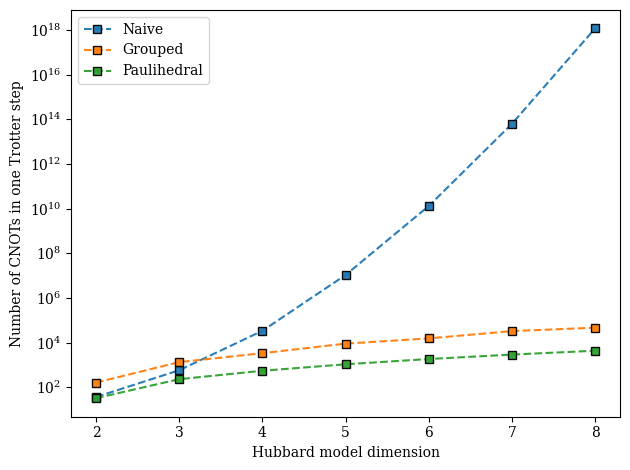

In [32]:
plt.rcParams.update({"font.family": "serif"})

kwargs = {"alpha": 0.95, "mec": "black"}

plt.plot(nvals, cnots_crude, "--s", **kwargs, label="Naive")
plt.plot(nvals, cnots_group, "--s", **kwargs, label="Grouped")
plt.plot(nvals, cnots_pauli, "--s", **kwargs, label="Paulihedral")

plt.xlabel("Hubbard model dimension")
plt.ylabel("Number of CNOTs in one Trotter step")
plt.legend()

plt.yscale("log");
plt.tight_layout()
# plt.savefig("trotter.pdf")